In [1]:
import numpy as np
import random
import copy
import math
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from scipy.spatial import ConvexHull, convex_hull_plot_2d

fittest_swarm = None
num_drones = 12
drone_id = 0
population = []
map_length = 150
map_width = 150
generations = 500
battery_life = 500
members_per_generation = 3
patience = 50

fittest_swarm_list = [[0],[0]]

In [2]:
# Class to represent a drone.
# id - drone's numerical ID
# x, y - coordinates of where the drone is
# x_move, y_move - the outputs of the neural network that control the direction the drones move
# coverage - the radius of the circular search area that the drone covers
# rely_on - the drone that self relies on for positioning. If the signal with this drone is too weak, self "dies"
# send_to - the drone that relies on self for positioning
# connected_to - list of drones that self is connected to
# is_alive - "alive" (True) when self is close enough to rely_on for signal, "dead" (False) otherwise
# nn - the neural network of this drone
class Drone:
    id = 0
    x = 0
    y = 0
    x_move = 0
    y_move = 0
    unsearched_N = 0
    unsearched_S = 0
    unsearched_W = 0
    unsearched_E = 0
    coverage = 10
    rely_on = None
    send_to = None
    connected_to = []
    is_alive = True
    nn = None
    swarm = None # drone knows what swarm it belongs to
    path = []
    actions = []
    
    # Initialize self variables
    def __init__(self):
        # Assign self id
        global drone_id
        self.id = drone_id
        drone_id += 1
        
        # Instantiate other self vars
        self.path = [[],[]]
        self.actions = [[],[]]
        
        self.connected_to = []
        self.rely_on = None
        self.send_to = None
        self.nn = None
        self.swarm = None
        
        self.unsearched_N = 1
        self.unsearched_S = 1
        self.unsearched_W = 1
        self.unsearched_E = 1
        
    # When printing drone object, it prints the drone's numerical id
    def __repr__(self):
        return str(self.id)
    
    def move(self, x_adj, y_adj):
        cancel = False
        for neighbor in self.connected_to:
            if coordinate_sig_strength(self.x + x_adj, neighbor.x, self.y + y_adj, neighbor.y) > 30:
                cancel = True

        # Move the drone based on the nn results        
        if not cancel:
            self.x += x_adj
            self.y += y_adj
            self.actions[0].append(x_adj)
            self.actions[1].append(y_adj)
            self.path[0].append(self.x)
            self.path[1].append(self.y)
    
    # Create and initialize the neural network
    def neural_init(self):
        self.nn = NeuralNetwork(self.get_input_layer())
    
    # Interprets what the input layer for the neural network should be at the time the func is called
    def get_input_layer(self):
        # Gets the signal strength between important drone connections. -1 if connection doesn't exist
        rely_on_sig = -1
        #print(self, "relies on", self.rely_on)
        if self.rely_on != None:
            rely_on_sig = drone_sig_strength(self, self.rely_on)
        
        #print(self, "sends to", self.send_to)
        send_to_sig = -1
        if self.send_to != None:
            send_to_sig = drone_sig_strength(self, self.send_to)
        
        #self.sense_surroundings()
        
        # Assembles the input layer using variables.
        #in_layer = [self.x, self.y, rely_on_sig, send_to_sig, self.x_move, self.y_move, self.unsearched_N*50, self.unsearched_S*50, self.unsearched_E*50, self.unsearched_W*50]
        in_layer = [self.x, self.y, rely_on_sig, send_to_sig, self.x_move, self.y_move]
        #in_layer = [sigmoid(self.x*5), sigmoid(self.y*5), sigmoid(rely_on_sig), sigmoid(send_to_sig), self.x_move, self.y_move]
        #out_layer_form = np.array([[0],[0],[0],[0]])
        in_layer = np.array([in_layer])
        #self.nn = NeuralNetwork(in_layer, out_layer_form)
        return in_layer
    
    # Feedforward the neural network. aka Find the output layer given an input_layer
    # Get input layer from get_input_layer()
    def neural_net_feedforward(self, input_layer):
        #print(input_layer)
        movement = self.nn.feedforward(input_layer)
        #print(self, movement)
        self.x_move = movement[0][0]
        self.y_move = movement[0][1]
        
    def sense_surroundings(self):
        sense = self.coverage + 1
        if int(self.x) + sense <= self.swarm.the_map.length and not self.swarm.the_map.search_points[int(self.x) + sense][int(self.y)][0]:
            self.unsearched_E = 1
        else:
            self.unsearched_E = 0
            
        if int(self.x) - sense >= 0 and not self.swarm.the_map.search_points[int(self.x) - sense][int(self.y)][0]:
            self.unsearched_W = 1
        else:
            self.unsearched_W = 0
            
        if int(self.y) + sense <= self.swarm.the_map.width and not self.swarm.the_map.search_points[int(self.x)][int(self.y) + sense][0]:
            self.unsearched_N = 1
        else:
            self.unsearched_N = 0
            
        if int(self.y) - sense >= 0 and not self.swarm.the_map.search_points[int(self.x)][int(self.y) - sense][0]:
            self.unsearched_S = 1
        else:
            self.unsearched_S = 0

In [3]:
# Function to turn any number into a number between 0 and 1
# Use a sine function because other functions didn't have enough variation in the output
# https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6 
def sigmoid(x):
    #print(x, '\n')
    #return 2*((1.0/(1+ np.exp(-0.5*(x-1)))-0.5))
    #return (np.sin(x)+1)*.5
    #return np.sin(math.pi * x - math.pi/2.0)
    return np.sin(math.pi * x - math.pi/2.0) * .5 +.5
    #return ((np.tanh(.05*(x-50))+1)*.5)

# Neural network class
class NeuralNetwork:
    # Weights between layers are randomly created
    def __init__(self, x):
        self.input      = x
        # 4 layers, 6 -> 4 -> 8 -> 2
        self.weights = [None] * 3
        self.weights[0]   = np.random.rand(self.input.shape[1], 4)
        self.weights[1]   = np.random.rand(4, 7)  
        self.weights[2]   = np.random.rand(7, 2)  
        
        #self.output = np.zeros(y.shape)
    
    # Input layer is fedforward through the nn and output layer is calculated
    def feedforward(self, input_layer):
        self.hidden_layers = [None] * 2
        #For simplicity, biases are assumed to be zero
        self.hidden_layers[0] = sigmoid(np.dot(input_layer, self.weights[0]))
        self.hidden_layers[1] = sigmoid(np.dot(self.hidden_layers[0], self.weights[1]))
        self.output = sigmoid(np.dot(self.hidden_layers[1], self.weights[2]))
        #print(self.output)
        return self.output

In [4]:
# used to get starting points for drones.
# n - number of drones/points
# r - radius of polygon/how far spread out they should be
# map_size - the size of the map the points will be plotted on (to put tha points in the center)
# returns - vertices, which is a 2 element long array. 
#    Element [0] is an array of all the x-component of points
#    Element [1] is an array of all the y-component of points
#    The same indices in each x and y list represent different components of the same point
#    Example: point 2's x value is at x[2] and the y value is at y[2]
def vertices_of_regpoly(n, r, map_length, map_width):
    vertices = []
    x = []
    y = []
    for i in range(0, n):
        x.append(( map_length / 2) + r * math.cos(2 * math.pi * i / n))
        y.append(( map_width /  2) + r * math.sin(2 * math.pi * i / n))
    vertices.append(x)
    vertices.append(y)
    return vertices

In [5]:
# Set each drone's initial locations to the drone's self.x and self.y values
def set_init_drones(swarm):
    xy = vertices_of_regpoly(num_drones, 2, swarm.the_map.length, swarm.the_map.width)
    for i in range(0, len(swarm.drones)):
        swarm.drones[i].x = xy[0][i]
        swarm.drones[i].y = xy[1][i]
        swarm.drones[i].x_move = 0
        swarm.drones[i].y_move = 0
        swarm.drones[i].is_alive = True
        swarm.drones[i].swarm = swarm

In [6]:
# The swarm class is a collection of drones
# It is also the "organism" unit of the population list, used in the Genetic Algorithm component of the program
# drones - list of drones in the population
# connectedness - matrix representing how the drones are connected to each other
class Swarm:
    drones = []
    connectedness = []
    fitness = 0
    battery_life = 0 # simulates a time limit to search an area
    battery_left = 0
    
    # Initialize the swarm
    def __init__(self, drones, map_length, map_width):
        global battery_life
        self.battery_life = battery_life
        self.battery_left = self.battery_life
        self.fitness = 0
        self.the_map = GeoMap(map_length, map_width) # The map to search
        self.drones = drones # the list of drones
        global drone_id # Reset the drone id counter for every swarm 
        drone_id = 0
        set_init_drones(self) # Set each drone's initial locations
        self.assign_connectedness()
        self.assign_drone_connect()
        self.rssi_table = []
        determine_architecture(self)
        determine_neighbors(self)
        for drone in self.drones:
            drone.neural_init()
    
    def __repr__(self):
        return str(self.fitness)
    
    def reset(self):
        self.battery_left = self.battery_life
        self.fitness = 0
        self.the_map = GeoMap(map_length, map_width) # The map to search
        set_init_drones(self) # Set each drone's initial locations
            
    # Randomly assign how the drones are connected to each other
    def assign_connectedness(self):
        #Make the swarm's connectivity matrix
        #This matrix is really only used for initial configuration
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        self.connectedness = np.zeros((len(self.drones),len(self.drones)))

        #The upper traingle of a mtrix w/o diagonal is filled in with 1s
        #the diagonal would mean drones are connected to themselves
        #the lower triangle is just a reflection
        #representation of the connections between drones
        for i in range(0,len(self.drones)):
            for j in range(0, i):
                self.connectedness[j][i] = 1

        # Ensure that each drone has at least one connection
        for i in range(0,len(self.drones)):
            possible_values = np.nonzero(self.connectedness[i])[0].tolist()
            choice = random.choice(possible_values) if possible_values else -1
            if choice != -1:
                possible_values.remove(choice)
            #Remaining choices have a possibility of not being connections (probability related to the number of drones)
            for value in possible_values:
                self.connectedness[i][value] = 0 if random.random() > 1.0/float(len(self.drones)) else 1

        #reflect over diagonal axis of matrix to make symmetric matrix
        for i in range(0,len(self.drones)):
            for j in range(0, i):
                self.connectedness[i][j] = self.connectedness[j][i]
    
    # After the swarm's connectedness is determines, each drone is told which drones it is connected to
    def assign_drone_connect(self):
        #Assign list connectedness in drones
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        for i in range(0,len(self.connectedness)):
            for j in range(0, len(self.connectedness)):
                if self.connectedness[i][j] == 1:
                    self.drones[i].connected_to.append(self.drones[j])
    
    # Determine the fitness of the swarm for purposes of evolution 
    # Fitness function takes all of these factors into account for spread:
    # Calculated area from vertices, each drone's distance from the center, drones' signal strength to each other,
    # search points when stationary, search points searched when traveling
    def determine_fitness(self):
        x = []
        y = []
        for drone in self.drones:
            x.append(drone.x)
            y.append(drone.y)
        #self.fitness += polygon_area(x,y) * .5
        #self.fitness += max_width_of_swarm_polygon(self.drones) * 100
#         for drone in self.drones:
#             for neighbor in drone.connected_to:
#                 self.fitness += drone_sig_strength(drone, neighbor)

        for i in range(0, len(self.drones)):
            drone_fitness = 1
            for j in range(i + 1, len(self.drones)):
                drone_fitness += drone_sig_strength(self.drones[i], self.drones[j])/num_drones
            self.fitness += drone_fitness

#         for i in range(0, len(self.drones)):
#             drone_fitness = 1
#             for j in range(0, len(drone.connected_to)):
#                 drone_fitness *= drone_sig_strength(self.drones[i], drone.connected_to[j])/num_drones
#             self.fitness += drone_fitness
                
    
    def search_percentage(self):
        return float(self.fitness)/float(self.the_map.get_total_points()) * 100

In [7]:
def polygon_area(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [8]:
def max_width_of_swarm_polygon(drones):
#     points = np.zeros(shape=(len(drones),2))
#     for i in range(0,len(drones)):
#         points[i][0] = drones[i].x
#         points[i][1] = drones[i].y
#     hull = ConvexHull(points)
    
#     plt.plot(points[:,0], points[:,1], 'o')
#     plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
#     plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
#     plt.show()

#     max_diag = 0
#     for i in range(0, len(hull.vertices)):
#         for j in range(i + 1, len(hull.vertices)):
#             drone1x = points[hull.vertices[i],0]
#             drone1y = points[hull.vertices[i],1]
#             drone2x = points[hull.vertices[j],0]
#             drone2y = points[hull.vertices[j],1]
#             diagonal = abs(math.hypot(drone2x - drone1x, drone2y - drone1y))
#             if diagonal > max_diag:
#                 max_diag = diagonal
#     return max_diag

    max_diag = 0
    for i in range(0, len(drones)):
        for j in range(i + 1, len(drones)):
            diagonal = abs(math.hypot(drones[j].x - drones[i].x, drones[j].y - drones[i].y))
            if diagonal > max_diag:
                max_diag = diagonal
    return max_diag

In [9]:
# This map class represents a geographical area that must be searched by a  swarm
# search_points - points in the map that will be checked if they have been searched or not. Represented by a matrix of booleans
class GeoMap:
    search_points = []
    #searched_points = set() # NOT CURRENTLY USED
    # Was explored as an alternative method to search points. Was just a list of points of where drones have been.
    def __init__(self, length, width):
        self.length = length
        self.width = width
        self.search_points = []
        self.populate_search_points()
    
    # Create a visualization of the map border
    def draw_map(self):
        plt.plot([0, 0,          self.length, self.length, 0], 
                 [0, self.width, self.width,  0,           0])
        self.disp_search_points()
        #self.disp_searched_points()
    
    # Create a visualization of which points in search_points have been searched
    def disp_search_points(self):
        for x in range(0, len(self.search_points)):
            for y in range(0, len(self.search_points[x])):
                if self.search_points[x][y][0]:
                    plt.plot(x, y, '.', color=self.search_points[x][y][1])
    
    # NOT CURRENTLY USED
    #def disp_searched_points(self):
        #for point in self.searched_points:
            #plt.plot(point[0], point[1], '.', color='green')
    
    # Initialize the map of search points
    def populate_search_points(self):
        for i in range(0, self.length + 2):
            row = []
            for j in range(0, self.width + 2):
                row.append([False, '#00FF00'])
            self.search_points.append(row)
            
    def get_total_points(self):
        return self.length * self.width

In [10]:
# Determine the architecture of the swarm in terms of which drone relies on which for positioning and communication
# Architecture is determined maximize the signal strength read between drones 
# (drones farther away from each other initially will not attempt to talk to each other directly)
def determine_architecture(swarm):
    coordinator = None
    for drone in swarm.drones:
        if coordinator == None:
            coordinator = drone
            rssi = 0
        else:
            rssi = drone_sig_strength(drone, coordinator)
        init_rssi_table(drone, rssi, swarm.rssi_table)
    sort_table_by_rssi(swarm.rssi_table)

In [11]:
# Initialize the signal strength table
def init_rssi_table(node_check, rssi, rssi_table):
    node = {}
    node["node"] = node_check
    node["rssi"] = rssi
    rssi_table.append(node)

In [12]:
# Sort the signal strength table
def sort_table_by_rssi(rssi_table):
    rssi_table.sort(key=lambda val: val["rssi"])

In [13]:
# Drones determine who they should rely_on for communication and who they should send_to 
# This is determined based o nthe ordering of the sorted signal-strength-architecture table
def determine_neighbors(swarm):
    if len(swarm.rssi_table) > 1:
        for index in range(0, len(swarm.rssi_table)):
            node = swarm.rssi_table[index]['node']
            if index == 0:
                node.rely_on = None
                node.send_to = swarm.rssi_table[index + 1]['node']
            elif index == len(swarm.rssi_table) - 1:
                node.rely_on = swarm.rssi_table[index - 1]['node']
                node.send_to = None
            else:
                node.rely_on = swarm.rssi_table[index - 1]['node']
                node.send_to = swarm.rssi_table[index + 1]['node']

In [14]:
# Create a starting population (generation 1) for the genetic algorithm
# size - how many members of the population should be created
# map_size - the size of the map of the world that the population should be simulated in
def create_starting_population(size, map_length, map_width):
    population = []
    
    global num_nodes
    for i in range(0,size):
        population.append(create_new_member([], map_length, map_width))
        
    return population

In [15]:
# Creates a new member of a population
# drones - list of drones for the population-member (swarm) (if list empty, drones will be created)
# map_size - the size of the map of the world that the population should be simulated in
def create_new_member(drones, map_length, map_width):
    if drones == []:
        global num_drones
        for i in range(0, num_drones):
            drones.append(Drone())
    member = Swarm(drones, map_length, map_width)
    return member

In [16]:
# Display a visualization of a swarm
def plot_swarm(swarm):
    fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
    for drone in swarm.drones:
        plt.plot(drone.x, drone.y, 'x', color='black')
        #print(drone.x, drone.y)
        #circle1 = plt.Circle((drone.x, drone.y), drone.coverage, color = 'b', fill=False)        
        #ax.add_artist(circle1)

    #fig.savefig('plotcircles.png')
        
    # Draws a visualization for the network connections    
    for row in range(0, num_drones - 1):
        for col in range(row + 1, num_drones):
            if swarm.connectedness[row][col] == 1:
                plt.plot([swarm.drones[row].x, swarm.drones[col].x], 
                         [swarm.drones[row].y, swarm.drones[col].y])

In [17]:
# Returns all the integer points that are within a given circle
# x0, y0 - the center of the circle
# radius - the radius of the circle
# NOT USED CURRENTLY
def points_in_circle(x0, y0, radius):
    x_ = np.arange(x0 - radius - 1, x0 + radius + 1, dtype=int)
    y_ = np.arange(y0 - radius - 1, y0 + radius + 1, dtype=int)
    x, y = np.where((x_[:,np.newaxis] - x0)**2 + (y_ - y0)**2 <= radius**2)
    # x, y = np.where((np.hypot((x_-x0)[:,np.newaxis], y_-y0)<= radius)) # alternative implementation
    for x, y in zip(x_[x], y_[y]):
        yield x, y
        plt.plot(x, y, '.', color='blue')

In [18]:
# Determine the distance between two drones
def drone_distance(drone1, drone2):
    return abs(math.hypot(drone2.x - drone1.x, drone2.y - drone1.y))

# Determine the signal strength between 2 drones using an RSSI formula
def drone_sig_strength(drone1, drone2):
    #return 20*math.log10(1/math.pow(drone_distance(drone1, drone2),2))
    #return 1/math.pow(drone_distance(drone1, drone2),2)
    dist = drone_distance(drone1, drone2)
    #print(dist)
    try:
        return  10*2*math.log10(dist) + 1
    except ValueError:
        return 0
    
def coordinate_distance(x1, x2, y1, y2):
    return abs(math.hypot(x2 - x1, y2 - y1))

def coordinate_sig_strength(x1, x2, y1, y2):
    dist = coordinate_distance(x1, x2, y1, y2)
    try:
        return  10*2*math.log10(dist) + 1
    except ValueError:
        return 0

# Determine the signal strength between all drones of an entire swarm
def swarm_sig_strength(swarm):
    swarm_strength = []
    
    for i in range(0, num_drones):
        for j in range(0, i):
            if swarm.connectedness[i][j] == 1:
                #print('Signal strength between drone ', i, ' and drone ', j, ': ', end='')
                #print(drone_sig_strength(swarm.drones[i], swarm.drones[j]))
                dist = drone_distance(swarm.drones[i], swarm.drones[j])
                sig_strength = drone_sig_strength(swarm.drones[i], swarm.drones[j])
                swarm_strength.append([[j, i], dist , sig_strength])
    return swarm_strength

In [19]:
# Check how many points in GeoMap's search_points have been searched
def check_drone_coverage(swarm):
    #Only check the points that are within the area that drones have been
    min_x = swarm.the_map.length + 1
    max_x = 0
    min_y = swarm.the_map.width + 1
    max_y = 0
    for drone in swarm.drones:
        if drone.x < min_x:
            min_x = drone.x
        if drone.x > max_x:
            max_x = drone.x
        if drone.y < min_y:
            min_y = drone.y
        if drone.y > max_y:
            max_y = drone.y
    
        #for circle_point in points_in_circle(drone.x, drone.y, drone.coverage):
            #the_map.searched_points.add(circle_point)

    #Check if points are within drone coverage
    for x in range(int(min_x - drone.coverage), int(max_x + drone.coverage) + 1):
        for y in range(int(min_y - drone.coverage), int(max_y + drone.coverage) + 1):
            for drone in swarm.drones:
                dist = math.sqrt(math.pow(x-drone.x, 2) + math.pow(y-drone.y, 2))
                if dist <= drone.coverage:
                    if x >= 0 and x <= swarm.the_map.length and y >= 0 and y <= swarm.the_map.width:
                        if not swarm.the_map.search_points[x][y][0]:
                            swarm.fitness += 1
                            swarm.the_map.search_points[x][y][0] = True
                        color = math.floor((swarm.battery_left/swarm.battery_life) * 255)
                        if color < 16:
                            swarm.the_map.search_points[x][y][1] = '#000' + str(hex(color))[2:] + '00'
                        else:
                            swarm.the_map.search_points[x][y][1] = '#00'  + str(hex(color))[2:] + '00'

    #print(swarm_sig_strength(swarm))
    #print(the_map.search_points)       

In [20]:
def search_area_limits(swarm):
    #Only check the points that are within the area that drones have been
    min_x = swarm.the_map.size + 1
    max_x = 0
    min_y = swarm.the_map.size + 1
    max_y = 0
    for drone in swarm.drones:
        if drone.x < min_x:
            min_x = drone.x
        if drone.x > max_x:
            max_x = drone.x
        if drone.y < min_y:
            min_y = drone.y
        if drone.y > max_y:
            max_y = drone.y
    return min_x, max_x, min_y, max_y

In [21]:
def check_coverage_population():
    for swarm in population:
        check_drone_coverage(swarm)

In [22]:
def set_map_size(ax=None):
    """ w, h: width, height in inches """
    w = .05*map_length
    h = .05*map_width
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [23]:
# Create a visualization of a swarm and the map it has searched
# swarm - the swarm to display
def draw_scene(swarm):
    plot_swarm(swarm)
    set_map_size()
    #swarm.the_map.draw_map()
    #print(swarm.search_percentage(), '%')
    print(swarm.fitness)

In [24]:
def plot_population():
    for swarm in population:
        draw_scene(swarm)
        #print(sorted(the_map.searched_points))
        #print(swarm_sig_strength(swarm))
        #print(swarm.fitness)
        #print(swarm.determine_fitness())

In [25]:
# Initialization of the main program
def init():
    global population
    global map_length
    global map_width
    global members_per_generation
    population = create_starting_population(members_per_generation, map_length, map_width)
    #check_coverage_population()
    #plot_population()
    #for swarm in population:
        #determine_architecture(swarm)
        #determine_neighbors(swarm)

In [26]:
# Drones randomly move around with no intelligence to attempt to search an area
def scatter():
    for swarm in population:
        while swarm.battery_left > 0:
            for drone in swarm.drones:
                if drone.is_alive:
                    x_adj = 0
                    y_adj = 0
                    x_adj += random.randint(-1, 1)
                    y_adj += random.randint(-1, 1)
                    #for circle_point in points_in_circle(drone.x, drone.y, drone.coverage):
                        #print(circle_point)
                        #the_map.searched_points.add(circle_point)
                   
                    #if drone.x < 0 or drone.x > swarm.the_map.size or drone.y < 0 or drone.y > swarm.the_map.size:
                        #drone.is_alive = False
                        
                    # Move the drone based on the nn results
                    if drone.x + x_adj >= 0 and drone.x + x_adj <= swarm.the_map.length:
                        drone.x += x_adj
                    if drone.y + y_adj >= 0 and drone.y + y_adj <= swarm.the_map.width:
                        drone.y += y_adj

                    check_drone_coverage(swarm)
                    
                    # If the drone strayed too far away from it's neighbor's, the drone is dead
                    if drone.rely_on != None and drone_sig_strength(drone, drone.rely_on) > 30:
                        drone.is_alive = False

                    if drone.send_to != None and drone_sig_strength(drone, drone.send_to) > 30:
                        drone.is_alive = False
                        
                    #for neighbor in drone.connected_to:
                        #if drone_sig_strength(drone, neighbor) > 30:
                            #drone.is_alive = False
            swarm.battery_left -= 1 

In [27]:
def move_drone_neurally(drone):
    # Interpret neural network results
    if drone.x_move < 0.33:
        x_adj = -1
    elif drone.x_move >= 0.33 and drone.x_move < .66:
        x_adj = 0
    elif drone.x_move >= .66:
        x_adj = 1

    if drone.y_move < 0.33:
        y_adj = -1
    elif drone.y_move >= 0.33 and drone.y_move < .66:
        y_adj = 0
    elif drone.y_move >= .66:
        y_adj = 1

    drone.move(x_adj, y_adj)

    drone.neural_net_feedforward(drone.get_input_layer())

In [28]:
def tug_on_drones(drone):
    if drone.x >= map_length/2:
        x_adj = 1
    elif drone.x < map_length/2:
        x_adj = -1
        
    if drone.y >= map_width/2:
        y_adj = 1
    elif drone.y < map_width/2:
        y_adj = -1
        
    drone.move(x_adj, y_adj)
        

In [29]:
# Drones move around via neural network results to attempt to search an area
def smart_scatter():
    for swarm in population:
        while swarm.battery_left > 0:
            for drone in swarm.drones: 
                move_drone_neurally(drone)
                #tug_on_drones(drone)
            swarm.battery_left -= 1 
        #check_drone_coverage(swarm)
        swarm.determine_fitness()

In [30]:
def hard_coded_search():
    for swarm in population:
            for drone in swarm.drones:
                d = 1
                batteryyy = map_length * map_width
                while (batteryyy > 0):
                    batteryyy -= 1
                    if d == 1 and drone.x < map_length:
                        drone.x += 1
                    if d == 1 and drone.x == map_length:
                        drone.y += 1
                        d = -1
                    if d == -1 and drone.y > 0:
                        drone.x -= 1
                    if d == -1 and drone.x == 0:
                        drone.y += 1
                        d = 1
                    check_drone_coverage(swarm)

In [31]:
def kill_off_the_weak():
    for unfortunate_soul in range(math.floor(len(population)/2), len(population)):
        population.pop()

In [32]:
def check_for_fittest():
    global fittest_swarm
    if fittest_swarm == None or population[0].fitness > fittest_swarm.fitness:
        fittest_swarm = copy.deepcopy(population[0])
        #check_drone_coverage(fittest_swarm)
        #draw_scene(fittest_swarm)
        print("NEW FITTEST:", fittest_swarm.fitness)
        print(datetime.datetime.now() - start_time)
        return True
    else:
        if len(population) == 1:
            population[0] = copy.deepcopy(fittest_swarm)
        return False

In [33]:
# GA function to mate/breed organisms of the population together
# Done so by swapping drones with each other
def mingle_the_genes():
    global population
    
    # Assigning metaphorical sex. M/F assignment only metaphorical for separating groups
    males = []
    females = []
    
    random.shuffle(population)
    for i in range(0, len(population), 2):
        males.append(population[i])
    for i in range(1, len(population), 2):
        females.append(population[i])

    if len(females) == 0:
        asexually_reproduce()
        
    else:
        for i in range(0, len(females)): #because females list will be shorter

            splice_site = random.randint(1, len(females[i].drones))

            males_front = males[i].drones[:splice_site]
            males_end   = males[i].drones[splice_site:]
            females_front = females[i].drones[:splice_site]
            females_end   = females[i].drones[splice_site:]

            offspring0_drones = copy.deepcopy(females_front + males_end)
            offspring1_drones = copy.deepcopy(males_front + females_end)

            population.append(create_new_member(offspring0_drones, map_length, map_width))
            population.append(create_new_member(offspring1_drones, map_length, map_width))
        

In [34]:
#Reset swarm population
def reset_population():
    for swarm in population:
        swarm.reset()

In [35]:
def mutate_population():
    mutations = 0
    global population
    for swarm in population:
        for drone in swarm.drones:
            for layer in drone.nn.weights:
                for node in layer:
                    for weight in range(0, len(node)):
                        chance = np.random.rand()
                        if chance > 0.9 + (.09 * (num_drones/(num_drones+5))):
                            (node[weight]) += np.random.rand() * random.randint(-1, 1)
                            mutations += 1
    print("MUTS: ", mutations)

In [36]:
# Reproduces/refills population asexually
def asexually_reproduce():
    for swarm in range(0, len(population)):
        swarm_copy = copy.deepcopy(population[swarm])
        population.append(swarm_copy)

In [37]:
def to_integer(dt_time):
    return dt_time.seconds

5
0 [68.36171362237897, 65.34499226952141, 60.462850588676986]
NEW FITTEST: 68.36171362237897
0:00:00.239117
MUTS:  35
1 [60.8319716769205, 60.46049280782494]
MUTS:  47
2 [66.66974086442627, 64.6445391044875, 62.03253319657841]
MUTS:  60
3 [68.09148414178819, 67.69846679679463, 62.97041302526971]
MUTS:  54
4 [66.71437717052106, 63.609057449760094, 60.15406844578622]
MUTS:  55
5 [68.50292152952593, 63.811030619656165, 60.68268985031764]
NEW FITTEST: 68.50292152952593
0:00:01.959509
MUTS:  35
6 [63.12518294212756, 58.35899925144799]
MUTS:  59
7 [61.955173141116084, 59.14068585430039, 58.02745101379797]
MUTS:  57
8 [63.07427669974125, 58.75854410572394, 58.57455175366558]
MUTS:  60
9 [61.66751283637188, 60.65203293364432, 57.016165312526496]
MUTS:  50
10 [67.05129518180348, 61.73351301764563, 61.636443744648645]
MUTS:  52
11 [67.91820813416876, 66.18163880931291, 64.27266640902349]
MUTS:  54
12 [62.23113998071082, 60.798777637752856, 56.96881639663197]
MUTS:  50
13 [66.40465137220447, 62.

MUTS:  89
30 [153.90569159129998, 147.9601840711334, 145.92002734182358]
MUTS:  81
31 [156.8923773628796, 152.64607858856695, 148.73845257222976]
MUTS:  84
32 [156.30779449623276, 151.57267412020255, 138.57549054809445]
MUTS:  79
33 [155.92490231258634, 150.1409659359312, 148.78091195417755]
MUTS:  86
34 [154.8144757642142, 148.9226153952254, 147.64154321837015]
MUTS:  78
35 [156.18536047122106, 156.02114807925403, 153.84054244540917]
MUTS:  80
36 [158.1021780162512, 149.60545758368573, 148.5525527503622]
MUTS:  68
37 [159.83097739376026, 152.69581680513215, 150.70224084144436]
MUTS:  64
38 [159.18931792684282, 147.86645336519533, 145.23780624927863]
MUTS:  89
39 [154.18734191918392, 151.42370102172958, 150.43363166371634]
MUTS:  96
40 [154.2331591355527, 151.44150020224177, 145.57794976077247]
MUTS:  74
41 [158.1682806647872, 156.95684054130112, 152.65235121753037]
MUTS:  73
42 [158.8734004934411, 153.7625892705905, 146.39937855895758]
MUTS:  73
43 [153.1204109131466, 150.151776835036

MUTS:  105
65 [244.49532979709258, 236.75382521294534, 236.15377935203924]
MUTS:  101
66 [243.83316183733047, 240.49760628152896, 239.5949934838145]
MUTS:  101
67 [251.89917470506197, 247.42614594402306, 246.0625726872115]
MUTS:  98
68 [245.84288274377164, 245.38860053374148, 244.2536481075892]
MUTS:  99
69 [247.31830663506, 241.8206619212676, 235.85176915171238]
MUTS:  88
70 [245.76100888681688, 242.41073165420644, 238.4414506043422]
MUTS:  96
71 [249.89151814373602, 246.41533507858136, 243.02508117069547]
MUTS:  101
72 [249.08911464262533, 248.5993776714738, 244.1322458293054]
MUTS:  78
73 [247.1215583256279, 242.82091083448964, 241.21872640374553]
MUTS:  96
74 [242.7322178683439, 236.70473240991635, 233.36116310895824]
MUTS:  112
75 [245.48530749578694, 241.17292254871265, 238.22934882725292]
MUTS:  106
76 [248.65203098398527, 245.60791598156786, 234.1959694809726]
MUTS:  96
77 [240.24381289423113, 239.83249898132163, 235.3598508346704]
MUTS:  83
78 [250.36802934286376, 248.17881248

MUTS:  99
69 [328.1062155276452, 326.6119836174429, 321.37109443212273]
MUTS:  123
70 [334.21265841559097, 331.86491200916834, 323.53219036762556]
MUTS:  111
71 [337.86658558594115, 328.16615261180476, 326.6876990151223]
MUTS:  120
72 [342.01025931001, 339.9570265398385, 315.8911300588634]
MUTS:  124
73 [332.55832034795253, 322.0458131734152, 317.5760085512583]
MUTS:  125
74 [331.6452845757807, 331.48552470993764, 323.29269925012926]
MUTS:  105
75 [333.7675782068419, 328.99243096075907, 321.98015715647085]
MUTS:  113
76 [331.8811310544264, 329.87412662831895, 320.9039556727899]
MUTS:  121
77 [337.24108958979457, 326.0196525367561, 318.1469954535072]
MUTS:  105
78 [332.09963311826976, 331.3116838397173, 324.19999836946437]
MUTS:  101
79 [341.2362982888706, 330.3989911954583, 329.6307860799524]
MUTS:  113
80 [333.29945322527624, 331.1233603445931, 325.40402240836113]
MUTS:  124
81 [330.4827074481441, 324.9624369564621, 323.9553099930801]
MUTS:  100
82 [331.33639226372605, 328.20612038967

MUTS:  113
26 [428.3254142155754, 411.1518380924191, 410.913495731632]
MUTS:  124
27 [427.59333161118815, 422.2707561854906, 418.61026479379854]
MUTS:  119
28 [425.7043322672265, 424.1172793670334, 409.417431120297]
MUTS:  109
29 [429.0105237998461, 419.9272859004235, 417.6457621062017]
MUTS:  132
30 [434.1257108122269, 416.20046859707895, 411.07843185128536]
MUTS:  102
31 [432.4897075847992, 429.79830245958505, 415.9747788750493]
MUTS:  133
32 [430.5018988326464, 424.93757462752956, 411.5370069530838]
MUTS:  131
33 [422.07097213531006, 415.60706883527854, 413.6884909431588]
MUTS:  126
34 [427.90439429501436, 422.5308471492119, 415.9742284216562]
MUTS:  105
35 [427.43131270616874, 420.5260172274084, 413.8798362512396]
MUTS:  111
36 [420.3497339340833, 420.1214388988834, 410.9937829621244]
MUTS:  140
37 [416.5989846139111, 413.40780720257203, 402.82107647977296]
MUTS:  136
38 [423.9295877433164, 419.16274494862347, 410.1859777650566]
MUTS:  116
39 [429.92035243845316, 427.56529733780786

MUTS:  139
72 [504.00043370764564, 501.8801287895277, 487.9329516633179]
MUTS:  171
73 [513.6850734486011, 502.01463322917255, 494.8512151724613]
MUTS:  147
74 [499.96860646161406, 495.7528476310702, 488.645496492757]
MUTS:  127
75 [508.4539305050857, 499.00702834553283, 491.1623041503018]
MUTS:  131
76 [507.81002424872514, 487.2642595566754, 483.58486750695346]
MUTS:  141
77 [499.8306011903904, 494.3852673590578, 488.84111916985097]
MUTS:  126
78 [523.2901442817459, 506.59049127054243, 496.26851743624354]
NEW FITTEST: 523.2901442817459
0:03:55.387392
MUTS:  93
79 [514.5684086479088, 500.2274404263504]
MUTS:  139
80 [516.7260327137616, 508.41866142747875, 508.0263959175401]
MUTS:  125
81 [514.0331972492136, 509.483112689659, 506.19443710978425]
MUTS:  134
82 [516.6540749502444, 506.9088296262492, 491.97846117602273]
MUTS:  127
83 [513.3912188430807, 503.5487731919376, 490.65880121345793]
MUTS:  142
84 [521.8518187567133, 507.9641286821417, 501.92097592081916]
MUTS:  150
85 [513.1130454

MUTS:  148
19 [602.3573375610943, 601.9557553869878, 583.7604565601056]
MUTS:  169
20 [588.2243861055443, 580.5082584466803, 572.5662632094146]
MUTS:  153
21 [598.9235060821137, 582.6001090105758, 574.763578605415]
MUTS:  144
22 [593.717774957632, 588.5376480512538, 582.7666637038411]
MUTS:  159
23 [606.8090325593931, 589.7106654957876, 585.9651002268208]
NEW FITTEST: 606.8090325593931
0:00:39.085982
MUTS:  93
24 [595.7135150853981, 590.9738860231719]
MUTS:  141
25 [598.7405244007228, 596.3583933335912, 591.5429149906913]
MUTS:  142
26 [598.0839586227177, 595.8822110972297, 581.3209281796675]
MUTS:  158
27 [593.073415948058, 587.9002463038596, 576.9784847461934]
MUTS:  138
28 [604.595126422095, 595.5160684120023, 593.3509063255209]
MUTS:  140
29 [601.4286242648012, 601.3795886152938, 593.1632193937397]
MUTS:  132
30 [603.3233287311051, 590.9562951641558, 590.2354429123257]
MUTS:  170
31 [590.8234986055913, 588.4633489358296, 585.4198403998896]
MUTS:  158
32 [607.4614744214126, 591.5712

MUTS:  96
11 [653.7724158694056, 648.5789620174569]
MUTS:  162
12 [650.9468954504018, 646.5664249810718, 630.9376590528561]
MUTS:  145
13 [660.0328586360184, 651.0947448202097, 644.6464606227254]
MUTS:  144
14 [662.4910159441866, 660.0856517509984, 648.1321333124846]
MUTS:  142
15 [651.6739605722145, 648.2111169112177, 646.0683362721632]
MUTS:  160
16 [644.4919176854278, 642.2084723338315, 641.5312316825906]
MUTS:  157
17 [657.0794633321962, 654.8171427965904, 651.8970838778155]
MUTS:  142
18 [657.2816725483581, 655.3194110381532, 639.012660308298]
MUTS:  155
19 [649.6021878855703, 644.0709041017419, 636.6226769116005]
MUTS:  192
20 [657.7731440338209, 648.3916180690949, 644.3589221973845]
MUTS:  135
21 [663.8038703745294, 644.9658705896885, 620.2658876272287]
MUTS:  159
22 [650.5120045062687, 631.0400792712318, 629.1211558197044]
MUTS:  164
23 [667.226015040044, 650.5719562325618, 648.3852921317576]
MUTS:  165
24 [655.6253737400798, 652.4748925397723, 649.4173744859404]
MUTS:  157
25 

121 [693.8423065725581, 691.2532114915039, 684.2697190257376]
MUTS:  160
122 [675.2076488810073, 664.6115563614501, 654.783219818846]
MUTS:  180
123 [694.1238893043444, 692.7022380222381, 665.9066245626367]
MUTS:  149
124 [693.5706085370796, 670.8253517076529, 654.1700427074148]
MUTS:  147
125 [696.1774017690708, 690.4461325593797, 671.9002348222652]
MUTS:  164
126 [691.1473735362898, 686.7135165152494, 675.7042033402082]
MUTS:  161
127 [688.5058290892147, 687.4107385184627, 679.449810950037]
MUTS:  184
128 [692.2527678162608, 692.153461468539, 645.8775445630014]
MUTS:  160
129 [690.7488781919415, 683.6567082463858, 658.9502101115678]
MUTS:  140
130 [691.0293392071623, 688.1488031981631, 671.4106381284665]
MUTS:  164
131 [685.5542828753577, 684.8144997090927, 671.6758463564252]
MUTS:  158
132 [689.889796413867, 680.3824176331252, 677.6988130888948]
MUTS:  159
133 [694.9678566145525, 691.9417283433718, 672.5071109763131]
MUTS:  145
134 [697.0583550348922, 694.2874003688071, 686.44186048

MUTS:  168
43 [777.0119265578315, 759.8927430107465, 752.7575069018517]
MUTS:  160
44 [759.695446205709, 759.2870141838589, 753.7801126162618]
MUTS:  175
45 [773.3091897879216, 769.0032815020423, 759.4206810814911]
MUTS:  160
46 [772.9252349551446, 759.1876197732039, 746.3808797155781]
MUTS:  161
47 [764.031448858888, 760.4451973628205, 733.3319248301257]
MUTS:  157
48 [783.4579462190027, 774.577057833265, 754.96527046462]
NEW FITTEST: 783.4579462190027
0:01:46.591186
MUTS:  127
49 [773.0278215762415, 765.9154787100827]
MUTS:  149
50 [783.6014859092862, 782.0319851383666, 756.2580011799777]
NEW FITTEST: 783.6014859092862
0:01:51.547130
MUTS:  118
51 [776.4441814084572, 767.8299101882405]
MUTS:  180
52 [765.0152902384524, 753.4868980538648, 744.5880839457191]
MUTS:  183
53 [784.2446582017674, 769.5510791551063, 758.160264068003]
NEW FITTEST: 784.2446582017674
0:01:59.811121
MUTS:  109
54 [780.1445308314338, 764.7675022106439]
MUTS:  182
55 [769.5556366670586, 768.9704603446851, 759.9711

MUTS:  151
154 [788.6123140502884, 777.8009088895491, 762.3217623306642]
MUTS:  172
155 [786.8240869530462, 774.5361623432708, 773.6746145151059]
MUTS:  154
156 [775.738923792865, 764.7133906170459, 748.4336447526757]
MUTS:  177
157 [789.4527645214581, 787.1303325760832, 759.3960941244834]
MUTS:  187
158 [789.8300517020641, 785.9413587823894, 763.6424218750993]
MUTS:  155
159 [765.2950018598436, 762.8049653106085, 756.1752766520987]
MUTS:  164
160 [782.8893894696668, 768.5906707082091, 763.8289373122748]
MUTS:  180
161 [785.5563515969665, 777.5461919563922, 776.2087308861672]
MUTS:  158
162 [783.4235993862006, 775.859493969104, 770.014484983916]
MUTS:  173
163 [772.1766861335967, 764.5576796197623, 763.2805177685557]
MUTS:  164
164 [796.5716300857862, 786.0170039628108, 769.8063052015403]
NEW FITTEST: 796.5716300857862
0:13:49.915432
MUTS:  102
165 [805.0856347153469, 799.7971546830743]
NEW FITTEST: 805.0856347153469
0:13:52.872362
MUTS:  121
166 [796.9997299239146, 796.1159158478914]


MUTS:  165
264 [806.7127751508173, 785.1930290095014, 780.7146168252615]
MUTS:  165
265 [804.8267692510465, 796.2586850525796, 794.8865067101424]
MUTS:  156
266 [797.8525127089808, 792.7699661438579, 791.4074820628297]
MUTS:  179
267 [808.2866485505411, 796.745456967886, 794.5663233596192]
MUTS:  156
268 [802.1984908662505, 801.5202867973396, 785.2033655867974]
MUTS:  167
269 [798.5322119776436, 794.456653855386, 780.3943634881787]
MUTS:  162
270 [783.3388924619694, 780.2840719683213, 776.6456680079037]
MUTS:  170
271 [815.444658406947, 803.629034071085, 791.694905632826]
MUTS:  166
272 [798.7591462704805, 795.7662655991028, 793.5558942497864]
MUTS:  162
273 [796.7104850806909, 795.6076447667307, 782.0869110221433]
MUTS:  180
274 [808.8431794557483, 785.3733256718544, 780.1258243479836]
MUTS:  181
275 [797.1339420493796, 790.8128803228564, 779.5923360029755]
MUTS:  182
276 [807.0009563519737, 797.5358880782619, 781.6458195806073]
MUTS:  170
277 [799.6865515785893, 787.9164254691325, 77

60 [823.2494891687367, 821.532927460375, 818.9566955112177]
MUTS:  174
61 [827.9612634062065, 814.6579054817513, 802.2366975630897]
MUTS:  148
62 [823.9786595908168, 823.4726650964138, 820.455569109644]
MUTS:  174
63 [838.7399460035429, 825.454961685921, 824.8580178946113]
MUTS:  172
64 [845.1294866442954, 820.6250077574091, 813.4755243274338]
NEW FITTEST: 845.1294866442954
0:03:16.885558
MUTS:  101
65 [842.4686880747221, 831.653184287986]
MUTS:  177
66 [840.8235499737458, 840.3351656128118, 839.4850634088872]
MUTS:  168
67 [833.299158234864, 823.1036225309799, 821.8411627802942]
MUTS:  182
68 [848.1076247333294, 847.3718724094421, 838.6132635427946]
NEW FITTEST: 848.1076247333294
0:03:30.433700
MUTS:  112
69 [836.5029266548308, 834.3205099340887]
MUTS:  147
70 [853.2578136539847, 842.8765265480333, 826.9770473534655]
NEW FITTEST: 853.2578136539847
0:03:37.009300
MUTS:  109
71 [861.0558935362964, 849.774727221882]
NEW FITTEST: 861.0558935362964
0:03:40.095241
MUTS:  116
72 [842.6334081

MUTS:  184
24 [946.5323078818207, 936.3456280003554, 927.4707139838076]
MUTS:  171
25 [940.1187700477162, 933.2076912843091, 915.0863117802429]
MUTS:  208
26 [926.1962227577349, 923.5827886120368, 917.3353569806526]
MUTS:  214
27 [939.287611288825, 935.571366946846, 921.3320737318328]
MUTS:  192
28 [968.657015677778, 945.9747448844245, 941.4282784274121]
NEW FITTEST: 968.657015677778
0:01:14.467235
MUTS:  116
29 [959.0509145659972, 945.6228056346123]
MUTS:  192
30 [965.9699158908243, 955.1609228477816, 932.4351392015067]
MUTS:  178
31 [961.8481630156658, 952.9731021971492, 939.799814307632]
MUTS:  209
32 [938.2518077244082, 921.2769156471602, 914.1817561800982]
MUTS:  163
33 [958.7014054082788, 955.0860627644776, 930.5244928398056]
MUTS:  170
34 [936.8007104732819, 928.6410970362452, 926.0134932787172]
MUTS:  175
35 [950.8414162466671, 941.0713111668551, 939.5587722892079]
MUTS:  182
36 [947.0155793133594, 945.708031537972, 943.4416071346553]
MUTS:  191
37 [946.887660058632, 945.857483

NEW FITTEST: 1011.9400933850259
0:01:19.573094
MUTS:  139
28 [1010.8771413779843, 997.549285499456]
MUTS:  203
29 [997.4173331441464, 995.274661858502, 988.8958602633015]
MUTS:  212
30 [999.2823637966052, 995.9007544406917, 988.569254188838]
MUTS:  191
31 [1000.2587088271597, 1000.1299093770057, 995.1771162228522]
MUTS:  200
32 [1009.4782777583945, 995.5981667568101, 989.7879213240537]
MUTS:  202
33 [1013.3716962845881, 1008.9787547765976, 990.7306882463419]
NEW FITTEST: 1013.3716962845881
0:01:39.433874
MUTS:  132
34 [1007.2398015043126, 1002.4788708897803]
MUTS:  202
35 [1015.4971219943156, 993.8407960574922, 988.3289661123999]
NEW FITTEST: 1015.4971219943156
0:01:45.365877
MUTS:  138
36 [1010.1787528766077, 1008.5192796068842]
MUTS:  183
37 [1006.3123587540337, 1002.8180656871617, 977.309295173121]
MUTS:  203
38 [1000.4879648228984, 998.7274855213819, 993.1903111068024]
MUTS:  214
39 [1005.631007172204, 1000.0945098554027, 985.7713383104843]
MUTS:  198
40 [1000.6925724571043, 995.89

MUTS:  207
20 [1070.1052876750832, 1061.2772409479578, 1036.2268736177352]
MUTS:  211
21 [1063.5527655772098, 1052.0610141532998, 1050.9429239100295]
MUTS:  206
22 [1076.0486517888019, 1067.1524563394669, 1062.2409029518524]
NEW FITTEST: 1076.0486517888019
0:01:13.795659
MUTS:  132
23 [1075.8428640966822, 1047.7944574349622]
MUTS:  214
24 [1073.1911606793233, 1063.7983565163458, 1054.0993724937164]
MUTS:  206
25 [1053.2818172339846, 1048.818575038379, 1046.4918568421238]
MUTS:  217
26 [1064.98240928017, 1057.2653583623169, 1053.567960827021]
MUTS:  209
27 [1058.5825251251836, 1055.707952095122, 1045.8808214051276]
MUTS:  221
28 [1065.8239235109163, 1056.3680254547178, 1051.1214939853455]
MUTS:  200
29 [1061.4202918088806, 1045.9368031300623, 1044.8665256028048]
MUTS:  189
30 [1099.624781487293, 1069.7740562986369, 1063.1792834564324]
NEW FITTEST: 1099.624781487293
0:01:40.213708
MUTS:  158
31 [1083.553828310823, 1070.537224380326]
MUTS:  215
32 [1096.013607124799, 1077.8328400675289, 1

MUTS:  190
128 [1107.106564459865, 1088.1992077918276, 1056.4699801099775]
NEW FITTEST: 1107.106564459865
0:07:32.667852
MUTS:  128
129 [1092.062323342077, 1077.8998502521363]
MUTS:  222
130 [1080.8590550310391, 1068.571787969521, 1061.2477861810237]
MUTS:  220
131 [1097.412215840788, 1092.5122437368632, 1084.81929263496]
MUTS:  219
132 [1082.8991709048469, 1075.278137849659, 1072.6431723551007]
MUTS:  226
133 [1097.9619528532444, 1087.8812053127153, 1074.5674370607428]
MUTS:  210
134 [1082.9456405869296, 1074.3955659038095, 1072.4582348226868]
MUTS:  213
135 [1083.8030898481675, 1081.4103977250256, 1058.067034205412]
MUTS:  227
136 [1076.4946132501318, 1071.8691672896723, 1049.5027465918777]
MUTS:  211
137 [1111.4017880540744, 1058.029498733513, 1048.0775072833069]
NEW FITTEST: 1111.4017880540744
0:08:18.778422
MUTS:  126
138 [1106.5740219903591, 1087.9425211795462]
MUTS:  235
139 [1116.856630371738, 1084.0560126534037, 1073.1418969159322]
NEW FITTEST: 1116.856630371738
0:08:26.091948

MUTS:  223
23 [1180.559328349213, 1167.0038593114102, 1156.9138249953937]
NEW FITTEST: 1180.559328349213
0:01:05.093997
MUTS:  132
24 [1171.3895168111433, 1163.0389473559367]
MUTS:  219
25 [1189.369246921791, 1177.5154702213476, 1156.6313971019324]
NEW FITTEST: 1189.369246921791
0:01:10.725261
MUTS:  176
26 [1189.6728906182152, 1162.6107252812735]
NEW FITTEST: 1189.6728906182152
0:01:13.070732
MUTS:  135
27 [1183.5704312255016, 1155.5676520238694]
MUTS:  247
28 [1182.2080085861912, 1181.3231563317374, 1155.8061611827038]
MUTS:  226
29 [1166.4701211902075, 1150.4514822911015, 1149.4103776040452]
MUTS:  215
30 [1184.9470756953592, 1168.449151546104, 1152.9576672669032]
MUTS:  245
31 [1173.6990820299177, 1166.4427422515435, 1139.2536244078638]
MUTS:  220
32 [1177.461205477018, 1158.5268972643053, 1147.1733611486065]
MUTS:  233
33 [1173.8209524940103, 1170.4096723560554, 1159.7665934750667]
MUTS:  232
34 [1164.3333073883007, 1163.5799235942302, 1153.9668166445008]
MUTS:  195
35 [1182.43441

MUTS:  215
130 [1208.800722858724, 1204.374833934305, 1196.2985747978637]
MUTS:  248
131 [1209.0834239248265, 1202.8652120457398, 1195.5800350530267]
MUTS:  230
132 [1207.4309852262613, 1200.0177242370928, 1196.2043357689975]
MUTS:  216
133 [1209.4412479245675, 1196.5757470408676, 1189.6696428216164]
MUTS:  227
134 [1208.1879818667414, 1206.3011670228366, 1203.0329986583706]
MUTS:  236
135 [1214.6658114045474, 1208.0569594166966, 1166.814593017175]
MUTS:  214
136 [1212.0500856006258, 1203.1770927064777, 1199.8265980273316]
MUTS:  244
137 [1209.0697330547994, 1197.214573882242, 1175.602008163803]
MUTS:  211
138 [1207.5198442265964, 1196.4548467266234, 1194.021854827259]
MUTS:  224
139 [1204.128599014313, 1197.8399755176706, 1193.492329435967]
MUTS:  228
140 [1207.7138327407245, 1195.835546814325, 1188.4216976356352]
MUTS:  228
141 [1201.4081499189826, 1182.853666186808, 1166.1244088770995]
MUTS:  223
142 [1207.2610281640364, 1201.4139358938614, 1166.8813700563803]
MUTS:  222
143 [1224.0

MUTS:  232
9 [1228.4414337284386, 1212.1066926989345, 1197.0583040868064]
MUTS:  252
10 [1249.787032876636, 1231.0477100324579, 1220.775105045147]
NEW FITTEST: 1249.787032876636
0:00:27.412504
MUTS:  163
11 [1257.2325443616917, 1241.3896089277537]
NEW FITTEST: 1257.2325443616917
0:00:29.463439
MUTS:  157
12 [1261.6331471146277, 1254.393972994145]
NEW FITTEST: 1261.6331471146277
0:00:31.611387
MUTS:  146
13 [1262.3635420564426, 1249.335675225167]
NEW FITTEST: 1262.3635420564426
0:00:33.777715
MUTS:  168
14 [1256.9616156468383, 1252.6722821379203]
MUTS:  226
15 [1265.0433311355234, 1247.3309307911218, 1232.4676700087157]
NEW FITTEST: 1265.0433311355234
0:00:39.330885
MUTS:  150
16 [1253.9048841938088, 1237.6565389758366]
MUTS:  254
17 [1255.988310722386, 1247.848602233647, 1236.8405201156088]
MUTS:  253
18 [1263.274156840678, 1260.5829159464224, 1235.0935763936266]
MUTS:  238
19 [1253.76246939544, 1242.8402758543912, 1241.4553271869847]
MUTS:  251
20 [1261.3881223834956, 1247.40092547563

MUTS:  253
114 [1287.6184049943647, 1269.268573889075, 1268.7603587809758]
MUTS:  231
115 [1276.804866277709, 1274.2952713984796, 1267.5167324429265]
MUTS:  237
116 [1280.846762939513, 1279.4926422991912, 1277.4402919739325]
MUTS:  227
117 [1289.055683683651, 1265.1983404086325, 1261.551068952005]
MUTS:  251
118 [1289.622584501976, 1276.162436292262, 1268.7071294182945]
MUTS:  265
119 [1288.0739925870082, 1286.0932541334178, 1278.3903114318266]
MUTS:  219
120 [1286.9462576171138, 1274.0870215407379, 1249.2457533067125]
MUTS:  243
121 [1284.3506688738526, 1283.025471101456, 1263.646862733347]
MUTS:  243
122 [1290.0531684788261, 1279.4812857798443, 1262.0815429708164]
MUTS:  236
123 [1275.7764393367913, 1272.6352000361692, 1267.2983375929316]
MUTS:  223
124 [1287.2618098053906, 1275.11362637916, 1267.7886807665407]
MUTS:  215
125 [1305.3333962273107, 1287.6902725007003, 1281.9436299564895]
MUTS:  232
126 [1300.7093118425983, 1294.8544170874156, 1290.749332118979]
MUTS:  201
127 [1297.499

MUTS:  243
16 [1312.2140998708737, 1306.187195500489, 1302.7430639639463]
MUTS:  255
17 [1301.8367767791656, 1292.3426640813427, 1289.3199191572241]
MUTS:  248
18 [1302.52277583184, 1288.3262183650484, 1280.654408017435]
MUTS:  221
19 [1311.5469743730055, 1296.8401815230782, 1266.5208429197842]
MUTS:  255
20 [1307.6189762448782, 1304.086022238338, 1266.6321832970552]
MUTS:  255
21 [1315.55871895956, 1308.820939780417, 1285.6993529461672]
MUTS:  251
22 [1319.8278973152972, 1310.9497884685086, 1292.177370344143]
MUTS:  240
23 [1294.953775617734, 1290.8365776229878, 1288.9774013579688]
MUTS:  230
24 [1307.586725685045, 1298.7848604567675, 1280.0683383867045]
MUTS:  240
25 [1312.6378474783558, 1289.129630315138, 1271.3753734387958]
MUTS:  256
26 [1298.976706006285, 1298.5809013546773, 1271.0127017146904]
MUTS:  222
27 [1305.7616836004504, 1295.5801844607108, 1289.4212607153454]
MUTS:  235
28 [1312.7620825148576, 1298.6001728715999, 1284.6060780274697]
MUTS:  234
29 [1336.7124770787548, 130

MUTS:  265
44 [1446.931369391333, 1440.4150727290937, 1422.3125428604073]
NEW FITTEST: 1446.931369391333
0:02:20.565567
MUTS:  155
45 [1449.0220008761537, 1439.4010606528634]
NEW FITTEST: 1449.0220008761537
0:02:23.163983
MUTS:  172
46 [1432.6045923525342, 1432.206599283085]
MUTS:  243
47 [1463.0565889763411, 1444.821714715196, 1436.6090970601447]
NEW FITTEST: 1463.0565889763411
0:02:29.928862
MUTS:  188
48 [1456.9621644166004, 1448.5630439657161]
MUTS:  247
49 [1442.0267067846319, 1431.4685816352082, 1427.5744390121483]
MUTS:  245
50 [1430.3657472110333, 1428.5602219210841, 1427.4781155889305]
MUTS:  260
51 [1453.925537790275, 1450.2543203487762, 1435.8329019353969]
MUTS:  247
52 [1442.5131177854796, 1430.3876034624461, 1426.7089606996017]
MUTS:  291
53 [1449.3970118588695, 1439.5254723387864, 1432.21205772774]
MUTS:  243
54 [1448.8908878421876, 1445.3058849778179, 1427.8292272126973]
MUTS:  253
55 [1448.8796876179556, 1445.6581762645233, 1440.3131821599807]
MUTS:  245
56 [1445.649227

MUTS:  261
52 [1496.543555642153, 1483.648737373581, 1471.779959538238]
MUTS:  247
53 [1485.5007830435216, 1483.3600197626301, 1475.5754144709497]
MUTS:  239
54 [1501.4455767171337, 1474.8027423448154, 1472.9811516767584]
MUTS:  290
55 [1495.29155269071, 1478.1639275857874, 1476.0330501749813]
MUTS:  259
56 [1496.2839258248712, 1483.905170279258, 1468.9912252458744]
MUTS:  275
57 [1480.8935787289772, 1454.0234154426266, 1451.2876427127567]
MUTS:  216
58 [1506.7201496869177, 1480.359655213419, 1469.504388726081]
NEW FITTEST: 1506.7201496869177
0:03:36.015827
MUTS:  185
59 [1493.863000474526, 1478.922356661711]
MUTS:  249
60 [1497.6633983178874, 1496.5484866899885, 1471.831662508824]
MUTS:  277
61 [1501.2299960188086, 1489.3703979203387, 1470.9823756099577]
MUTS:  271
62 [1494.3821143703208, 1490.0458687011353, 1465.034974429431]
MUTS:  245
63 [1492.4574953576487, 1480.2494389788076, 1470.9721440839767]
MUTS:  267
64 [1503.118636165433, 1492.6799092886624, 1490.4540060278132]
MUTS:  267


MUTS:  268
158 [1529.009131820779, 1509.8634423149724, 1493.235499358094]
MUTS:  248
159 [1544.4576309196086, 1539.7602896726637, 1525.659431976197]
MUTS:  261
160 [1536.03182720462, 1529.1381955567888, 1514.2049592887536]
MUTS:  276
161 [1534.3409732888952, 1524.3449460589243, 1522.791946112689]
MUTS:  235
162 [1540.62993269516, 1539.385435380429, 1532.755390866985]
MUTS:  241
163 [1540.6826550214969, 1525.0080408740496, 1503.9829923747086]
MUTS:  258
164 [1530.6191237271146, 1527.3885327651326, 1503.5333806809444]
MUTS:  278
165 [1530.9404882128156, 1505.788113107497, 1488.5703935542494]
MUTS:  244
166 [1532.5742673092013, 1520.7307249918076, 1520.668643289981]
MUTS:  267
167 [1533.3708572926614, 1527.6654097518956, 1508.4209650602447]
MUTS:  279
168 [1531.1936234672653, 1523.8979299638793, 1501.7730193812567]
MUTS:  247
169 [1545.6675706231301, 1524.4768614205257, 1517.290874627558]
MUTS:  248
170 [1533.2003161529271, 1527.2755178966963, 1525.692287500841]
MUTS:  252
171 [1546.59840

MUTS:  270
84 [1621.4574756911566, 1605.5199728157938, 1598.1201618405705]
MUTS:  275
85 [1608.4544131023458, 1606.067039470789, 1596.6867489083925]
MUTS:  268
86 [1603.1077504720924, 1581.335643578, 1571.303446198014]
MUTS:  281
87 [1616.9403877790214, 1605.706636891343, 1601.7613550706458]
MUTS:  295
88 [1615.7882345185174, 1614.0944485565396, 1595.4423185346907]
MUTS:  274
89 [1618.1765142158392, 1597.3691496455249, 1581.213958887987]
MUTS:  257
90 [1598.425601231666, 1593.0710644966025, 1589.329793970464]
MUTS:  257
91 [1601.1704830556262, 1600.6586903668176, 1590.6639478378936]
MUTS:  246
92 [1603.2139448009827, 1600.2255345493115, 1586.314551566558]
MUTS:  271
93 [1609.5684336753889, 1603.9690569544225, 1587.3476560971008]
MUTS:  268
94 [1623.735192833251, 1614.5674516483919, 1601.729812408215]
MUTS:  276
95 [1612.131628291626, 1597.0379687763184, 1583.5434952614978]
MUTS:  259
96 [1620.1887580570838, 1606.0807179081803, 1585.2624857816015]
MUTS:  304
97 [1598.3613306845127, 1593

MUTS:  287
14 [1669.175119221466, 1661.7806313717963, 1660.2447257912247]
NEW FITTEST: 1669.175119221466
0:00:59.300940
MUTS:  207
15 [1671.413785311078, 1652.213676010991]
NEW FITTEST: 1671.413785311078
0:01:02.977847
MUTS:  194
16 [1687.0953223385884, 1651.8597479717127]
NEW FITTEST: 1687.0953223385884
0:01:06.695842
MUTS:  174
17 [1681.9893232317818, 1676.869141162922]
MUTS:  255
18 [1686.6265617493261, 1673.5759907085098, 1669.9959641174282]
MUTS:  300
19 [1680.4052579073414, 1670.8066124374204, 1645.6076241307376]
MUTS:  288
20 [1686.4688271828204, 1668.0468096711247, 1655.036912697983]
MUTS:  269
21 [1683.8446764923976, 1681.9194189105385, 1658.537725371316]
MUTS:  261
22 [1667.9893335568836, 1657.4165223937757, 1647.7126349679058]
MUTS:  268
23 [1691.2062100861053, 1681.7861049862715, 1675.00629593281]
NEW FITTEST: 1691.2062100861053
0:01:45.784049
MUTS:  203
24 [1693.6679999883156, 1678.8629973927407]
NEW FITTEST: 1693.6679999883156
0:01:49.738301
MUTS:  177
25 [1675.8510733269

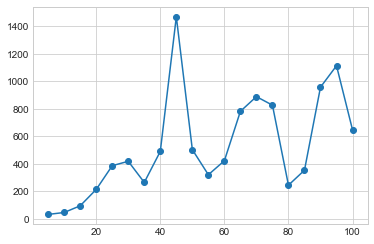

In [38]:
exec_time_vs_num_drones = [[],[]]
for num in range(5, 101, 5):
    num_drones = num
    print(num_drones)
    
    drone_id = 0
    population = []
    fittest_swarm = None
    fittest_swarm_list = [[0],[0]]
    
    init()

    start_time = datetime.datetime.now()

    if members_per_generation > 1:
        for i in range(0, generations):
#         i = 0
#         while i < fittest_swarm_list[0][len(fittest_swarm_list[0])-1] + patience:
#             i += 1
            print(i, end=" ")
            smart_scatter()
            population.sort(key=lambda x: x.fitness, reverse=True)
            print(population)
            kill_off_the_weak()
            is_new_fittest = check_for_fittest()
            #mingle_the_genes()
            asexually_reproduce()
            if is_new_fittest:
                fittest_swarm_list[1].append(fittest_swarm.fitness)
                fittest_swarm_list[0].append(i)
            else:
                population.append(copy.deepcopy(fittest_swarm))
            reset_population()
            mutate_population()
    else:
        i = 0
        while i < fittest_swarm_list[0][len(fittest_swarm_list[0])-1] + patience:
            print(i, end=" ")
            i += 1
            smart_scatter()
            population.sort(key=lambda x: x.fitness, reverse=True)
            print(population)
            if check_for_fittest():
                fittest_swarm_list[1].append(fittest_swarm.fitness)
                fittest_swarm_list[0].append(i)
            reset_population()
            mutate_population()

    exec_time = datetime.datetime.now() - start_time
    print(exec_time, to_integer(exec_time))
    exec_time_vs_num_drones[0].append(to_integer(exec_time))
    exec_time_vs_num_drones[1].append(num_drones)

    #check_drone_coverage(fittest_swarm)
#     draw_scene(fittest_swarm)

#     # Draws a visualization for the swarm path   
#     for drone in fittest_swarm.drones:
#         set_map_size()
#         plt.plot(drone.path[0], drone.path[1])
#         population[0].the_map.draw_map()

#     set_map_size()
#     plt.plot(fittest_swarm_list[0], fittest_swarm_list[1], '-o')

plt.plot(exec_time_vs_num_drones[1], exec_time_vs_num_drones[0], '-o')